In [1]:
from tg.grammar_ru.common import *
from tg.projects.alternative import BundleBuilder, BundleConfig
from tg.projects.alternative import EndingNegativeSampler
from tg.grammar_ru import features as fe

tsa_sampler = EndingNegativeSampler('тся','ться')


config = BundleConfig(
    [
        Loc.corpus_path/'pub.base.zip',
        Loc.corpus_path/'books.base.zip',
        Loc.corpus_path/'lenta.base.zip'
    ],
    None,
    tsa_sampler,
    [
        fe.PyMorphyFeaturizer(),
        fe.SlovnetFeaturizer(),
        fe.SyntaxTreeFeaturizer(),
        fe.SyntaxStatsFeaturizer()
        
    ],
    Loc.temp_path/'tsa/',
)

builder = BundleBuilder(config)

In [2]:
from typing import *
import pandas as pd
from tg.grammar_ru.algorithms import SpellcheckAlgorithm
import numpy as np
from yo_fluq_ds import *


def _count_verbs(dfs: Iterable[pd.DataFrame]):
    counter = {}
    for df in dfs:
        df = df.loc[df.word.str.endswith('тся') | df.word.str.endswith('ться')]
        for word in df.word.str.lower():
            counter[word] = counter.get(word,0)+1
    return counter


def _another(w):
    if w.endswith('тся'):
        return w.replace('тся', 'ться')
    else:
        return w.replace('ться', 'тся')


def _get_good_words_df(words):
    for w in list(words):
        if _another(w) not in words:
            words[_another(w)] = 0

    rows = []
    for w in words:
        if w.endswith('ться'):
            rows.append((w,_another(w),words[w], words[_another(w)]))

    df = pd.DataFrame(rows, columns=['i_word','f_word','i_cnt','f_cnt'])
    df['both_found'] = df[['i_cnt','f_cnt']].min(axis=1)>0
    df = df[df.both_found]
    df['ratio'] = np.minimum(df.i_cnt/df.f_cnt, df.f_cnt/df.i_cnt)

    alg = SpellcheckAlgorithm()
    for prefix in ['i_', 'f_']:
        xdf = pd.DataFrame(dict(word=df[prefix+'word'], word_type='ru'))
        kdf = alg.run(DataBundle(src=xdf))
        df[prefix+'spell'] = ~kdf.error

    df['both_correct'] = df.i_spell & df.f_spell
    df = df.loc[df.both_correct]
    return df


def build_dictionary(dfs):
    cnt = _count_verbs(dfs)
    df = _get_good_words_df(cnt)
    good_words = set(df.i_word).union(df.f_word)
    return good_words

dict_path = Loc.data_cache_path/'tasks/tsa-dict.json'
os.makedirs(dict_path.parent, exist_ok = True)
if not os.path.isfile(dict_path):
    tsa_dict = build_dictionary(builder.get_all_frames(True))
    FileIO.write_json(list(tsa_dict), dict_path)
else:
    tsa_dict = FileIO.read_json(dict_path)

In [3]:
from tg.projects.alternative import DictionaryFilterer

builder.config.filterer = DictionaryFilterer(tsa_dict)
buckets_path = Loc.data_cache_path/'tasks/tsa_buckets.parquet'
if not os.path.isfile(buckets_path):
    buckets = builder.compute_buckets()
    buckets.to_parquet(buckets_path)
else:
    buckets= pd.read_parquet(buckets_path)

In [4]:
buckets

,corpus_id,sentence_id,len,log_len
0,pub.base.zip,1,27,4
1,pub.base.zip,4,20,4
2,pub.base.zip,7,15,3
3,pub.base.zip,25,7,2
4,pub.base.zip,27,15,3
...,...,...,...,...
456855,lenta.base.zip,169870935,16,4
456856,lenta.base.zip,169870976,20,4
456857,lenta.base.zip,169871029,21,4
456858,lenta.base.zip,169871039,18,4


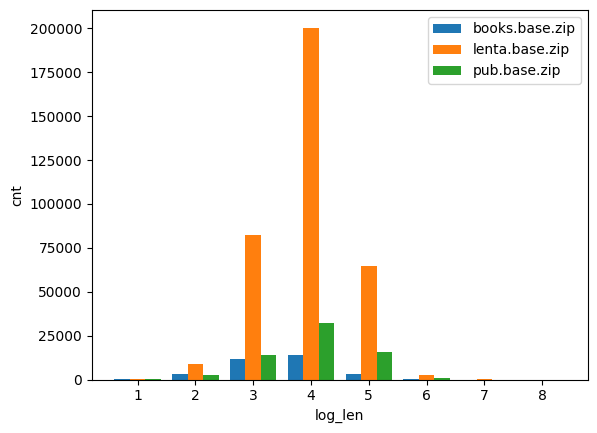

In [5]:
from tg.common.analysis import grbar_plot

ax = grbar_plot(
    buckets.groupby(['corpus_id','log_len']).size().to_frame('cnt').reset_index(),
    value_column='cnt',
    color_column='corpus_id',
    group_column='log_len'
)
ax.legend()

In [6]:
import numpy as np
df = buckets.copy()
df['random'] = np.random.rand(df.shape[0])
df = df.feed(fluq.add_ordering_column(['corpus_id', 'log_len'], 'random'))
df = df.loc[df.order<5000]
df.shape[0]

58292

In [7]:
if False:
    builder.prepare(df)
    builder.featurize()

In [8]:
if False:
    builder.assemble(None, Loc.bundles_path/'alt/tsa-full')
    builder.assemble(1, Loc.bundles_path/'alt/tsa-mini')

In [9]:
from tg.common.ml.batched_training import train_display_test_split

def build_index(bundle):
    path = Loc.bundles_path/'alt'/bundle
    src = pd.read_parquet(path/'src.parquet')
    print(bundle, src.drop_duplicates('sentence_id').shape[0])
    idf = src.loc[src.is_target][['word_id','sentence_id','label']]
    idf.index.name = 'sample_id'
    idf['split'] = train_display_test_split(idf)
    idf.to_parquet(path/'index.parquet')
    
for bundle in ['tsa-full','tsa-mini']:
    build_index(bundle)

tsa-full 118643
tsa-mini 2098


In [10]:
config_mini = BundleConfig(
    [
        Loc.corpus_path/'lenta.base.zip'
    ],
    DictionaryFilterer(tsa_dict),
    tsa_sampler,
    [
        fe.PyMorphyFeaturizer(),
    ],
    Loc.temp_path/'tsa-mini/',
)
builder_mini = BundleBuilder(config_mini)
df_mini = buckets.loc[(buckets.corpus_id=='lenta.base.zip') & (buckets.len==10)]
print(df_mini.shape)
builder_mini.prepare(df_mini)
builder_mini.featurize()
builder_mini.assemble(None, Loc.bundles_path/'alt/tsa-test')
build_index('tsa-test')

(8748, 4)
2023-02-03 12:04:04.390605 INFO: Processed 100 words. 1/988
2023-02-03 12:04:04.443740 INFO: Processed 200 words. 1/988
2023-02-03 12:04:04.770392 INFO: Processed 290 words. 2/988
2023-02-03 12:04:04.848110 INFO: Processed 380 words. 2/988
2023-02-03 12:04:05.193819 INFO: Processed 450 words. 3/988
2023-02-03 12:04:05.240342 INFO: Processed 520 words. 3/988
2023-02-03 12:04:05.511623 INFO: Processed 590 words. 4/988
2023-02-03 12:04:05.560311 INFO: Processed 660 words. 4/988
2023-02-03 12:04:05.844115 INFO: Processed 790 words. 5/988
2023-02-03 12:04:05.881663 INFO: Processed 920 words. 5/988
2023-02-03 12:04:06.162654 INFO: Processed 940 words. 6/988
2023-02-03 12:04:06.214987 INFO: Processed 960 words. 6/988
2023-02-03 12:04:06.580213 INFO: Processed 1010 words. 7/988
2023-02-03 12:04:06.644176 INFO: Processed 1060 words. 7/988
2023-02-03 12:04:06.994409 INFO: Processed 1110 words. 8/988
2023-02-03 12:04:07.040444 INFO: Processed 1160 words. 8/988
2023-02-03 12:04:07.381235

2023-02-03 12:04:20.273204 INFO: Processed 12200 words. 66/988
2023-02-03 12:04:20.444203 INFO: Processed 12230 words. 67/988
2023-02-03 12:04:20.471197 INFO: Processed 12260 words. 67/988
2023-02-03 12:04:20.641063 INFO: Processed 12350 words. 68/988
2023-02-03 12:04:20.659360 INFO: Processed 12440 words. 68/988
2023-02-03 12:04:20.834613 INFO: Processed 12570 words. 69/988
2023-02-03 12:04:20.857404 INFO: Processed 12700 words. 69/988
2023-02-03 12:04:21.031402 INFO: Processed 12830 words. 70/988
2023-02-03 12:04:21.057566 INFO: Processed 12960 words. 70/988
2023-02-03 12:04:21.306886 INFO: Processed 13000 words. 71/988
2023-02-03 12:04:21.346868 INFO: Processed 13040 words. 71/988
2023-02-03 12:04:21.542991 INFO: Processed 13120 words. 72/988
2023-02-03 12:04:21.575020 INFO: Processed 13200 words. 72/988
2023-02-03 12:04:21.769132 INFO: Processed 13260 words. 73/988
2023-02-03 12:04:21.797775 INFO: Processed 13320 words. 73/988
2023-02-03 12:04:21.983724 INFO: Processed 13390 words.

2023-02-03 12:04:33.432318 INFO: Processed 24540 words. 131/988
2023-02-03 12:04:33.609141 INFO: Processed 24570 words. 132/988
2023-02-03 12:04:33.630181 INFO: Processed 24600 words. 132/988
2023-02-03 12:04:33.808722 INFO: Processed 24700 words. 133/988
2023-02-03 12:04:33.828086 INFO: Processed 24800 words. 133/988
2023-02-03 12:04:34.010654 INFO: Processed 24930 words. 134/988
2023-02-03 12:04:34.033747 INFO: Processed 25060 words. 134/988
2023-02-03 12:04:34.210310 INFO: Processed 25100 words. 135/988
2023-02-03 12:04:34.232532 INFO: Processed 25140 words. 135/988
2023-02-03 12:04:34.410851 INFO: Processed 25190 words. 136/988
2023-02-03 12:04:34.440262 INFO: Processed 25240 words. 136/988
2023-02-03 12:04:34.610367 INFO: Processed 25280 words. 137/988
2023-02-03 12:04:34.639369 INFO: Processed 25320 words. 137/988
2023-02-03 12:04:34.817771 INFO: Processed 25390 words. 138/988
2023-02-03 12:04:34.845214 INFO: Processed 25460 words. 138/988
2023-02-03 12:04:35.036121 INFO: Process

2023-02-03 12:04:48.554219 INFO: Processed 36110 words. 195/988
2023-02-03 12:04:48.757219 INFO: Processed 36260 words. 196/988
2023-02-03 12:04:48.782561 INFO: Processed 36410 words. 196/988
2023-02-03 12:04:48.950330 INFO: Processed 36480 words. 197/988
2023-02-03 12:04:48.975194 INFO: Processed 36550 words. 197/988
2023-02-03 12:04:49.165562 INFO: Processed 36580 words. 198/988
2023-02-03 12:04:49.207287 INFO: Processed 36610 words. 198/988
2023-02-03 12:04:49.247236 INFO: Processed 36620 words. 198/988
2023-02-03 12:04:49.395948 INFO: Processed 36700 words. 199/988
2023-02-03 12:04:49.409802 INFO: Processed 36780 words. 199/988
2023-02-03 12:04:49.567918 INFO: Processed 36860 words. 200/988
2023-02-03 12:04:49.601229 INFO: Processed 36940 words. 200/988
2023-02-03 12:04:49.791296 INFO: Processed 37010 words. 201/988
2023-02-03 12:04:49.808643 INFO: Processed 37080 words. 201/988
2023-02-03 12:04:50.079411 INFO: Processed 37130 words. 202/988
2023-02-03 12:04:50.125595 INFO: Process

2023-02-03 12:04:58.734833 INFO: Processed 48220 words. 259/988
2023-02-03 12:04:58.845255 INFO: Processed 48330 words. 260/988
2023-02-03 12:04:58.858857 INFO: Processed 48440 words. 260/988
2023-02-03 12:04:58.962411 INFO: Processed 48490 words. 261/988
2023-02-03 12:04:58.976219 INFO: Processed 48540 words. 261/988
2023-02-03 12:04:59.088323 INFO: Processed 48610 words. 262/988
2023-02-03 12:04:59.101779 INFO: Processed 48680 words. 262/988
2023-02-03 12:04:59.206503 INFO: Processed 48770 words. 263/988
2023-02-03 12:04:59.220617 INFO: Processed 48860 words. 263/988
2023-02-03 12:04:59.326224 INFO: Processed 48990 words. 264/988
2023-02-03 12:04:59.341060 INFO: Processed 49120 words. 264/988
2023-02-03 12:04:59.446065 INFO: Processed 49220 words. 265/988
2023-02-03 12:04:59.461803 INFO: Processed 49320 words. 265/988
2023-02-03 12:04:59.566935 INFO: Processed 49400 words. 266/988
2023-02-03 12:04:59.582203 INFO: Processed 49480 words. 266/988
2023-02-03 12:04:59.691595 INFO: Process

2023-02-03 12:05:15.699707 INFO: Processed 59830 words. 323/988
2023-02-03 12:05:15.763707 INFO: Processed 59920 words. 323/988
2023-02-03 12:05:16.000208 INFO: Processed 60000 words. 324/988
2023-02-03 12:05:16.025356 INFO: Processed 60080 words. 324/988
2023-02-03 12:05:16.271186 INFO: Processed 60170 words. 325/988
2023-02-03 12:05:16.309697 INFO: Processed 60260 words. 325/988
2023-02-03 12:05:16.583491 INFO: Processed 60330 words. 326/988
2023-02-03 12:05:16.615930 INFO: Processed 60400 words. 326/988
2023-02-03 12:05:16.849973 INFO: Processed 60470 words. 327/988
2023-02-03 12:05:16.882042 INFO: Processed 60540 words. 327/988
2023-02-03 12:05:17.140445 INFO: Processed 60640 words. 328/988
2023-02-03 12:05:17.166427 INFO: Processed 60740 words. 328/988
2023-02-03 12:05:17.382433 INFO: Processed 60850 words. 329/988
2023-02-03 12:05:17.418596 INFO: Processed 60960 words. 329/988
2023-02-03 12:05:17.664497 INFO: Processed 61120 words. 330/988
2023-02-03 12:05:17.698575 INFO: Process

2023-02-03 12:05:25.652790 INFO: Processed 70560 words. 386/988
2023-02-03 12:05:25.812310 INFO: Processed 70650 words. 387/988
2023-02-03 12:05:25.831703 INFO: Processed 70740 words. 387/988
2023-02-03 12:05:25.935978 INFO: Processed 70800 words. 388/988
2023-02-03 12:05:25.949606 INFO: Processed 70860 words. 388/988
2023-02-03 12:05:26.057702 INFO: Processed 70960 words. 389/988
2023-02-03 12:05:26.072685 INFO: Processed 71060 words. 389/988
2023-02-03 12:05:26.179230 INFO: Processed 71130 words. 390/988
2023-02-03 12:05:26.192702 INFO: Processed 71200 words. 390/988
2023-02-03 12:05:26.299781 INFO: Processed 71330 words. 391/988
2023-02-03 12:05:26.313283 INFO: Processed 71460 words. 391/988
2023-02-03 12:05:26.418533 INFO: Processed 71560 words. 392/988
2023-02-03 12:05:26.433777 INFO: Processed 71660 words. 392/988
2023-02-03 12:05:26.535750 INFO: Processed 71760 words. 393/988
2023-02-03 12:05:26.549064 INFO: Processed 71860 words. 393/988
2023-02-03 12:05:26.665433 INFO: Process

2023-02-03 12:05:34.611563 INFO: Processed 82120 words. 451/988
2023-02-03 12:05:34.645915 INFO: Processed 82240 words. 451/988
2023-02-03 12:05:34.757269 INFO: Processed 82330 words. 452/988
2023-02-03 12:05:34.772991 INFO: Processed 82420 words. 452/988
2023-02-03 12:05:34.898674 INFO: Processed 82480 words. 453/988
2023-02-03 12:05:34.917981 INFO: Processed 82540 words. 453/988
2023-02-03 12:05:35.024174 INFO: Processed 82620 words. 454/988
2023-02-03 12:05:35.038307 INFO: Processed 82700 words. 454/988
2023-02-03 12:05:35.143809 INFO: Processed 82790 words. 455/988
2023-02-03 12:05:35.157380 INFO: Processed 82880 words. 455/988
2023-02-03 12:05:35.262056 INFO: Processed 83020 words. 456/988
2023-02-03 12:05:35.276426 INFO: Processed 83160 words. 456/988
2023-02-03 12:05:35.377600 INFO: Processed 83210 words. 457/988
2023-02-03 12:05:35.391050 INFO: Processed 83260 words. 457/988
2023-02-03 12:05:35.499522 INFO: Processed 83360 words. 458/988
2023-02-03 12:05:35.513011 INFO: Process

2023-02-03 12:05:43.446186 INFO: Processed 92900 words. 515/988
2023-02-03 12:05:43.461458 INFO: Processed 93010 words. 515/988
2023-02-03 12:05:43.584475 INFO: Processed 93120 words. 516/988
2023-02-03 12:05:43.599942 INFO: Processed 93230 words. 516/988
2023-02-03 12:05:43.707426 INFO: Processed 93290 words. 517/988
2023-02-03 12:05:43.720811 INFO: Processed 93350 words. 517/988
2023-02-03 12:05:43.831239 INFO: Processed 93470 words. 518/988
2023-02-03 12:05:43.844948 INFO: Processed 93590 words. 518/988
2023-02-03 12:05:43.950234 INFO: Processed 93650 words. 519/988
2023-02-03 12:05:43.966088 INFO: Processed 93710 words. 519/988
2023-02-03 12:05:44.119488 INFO: Processed 93770 words. 520/988
2023-02-03 12:05:44.135392 INFO: Processed 93830 words. 520/988
2023-02-03 12:05:44.289958 INFO: Processed 93930 words. 521/988
2023-02-03 12:05:44.305747 INFO: Processed 94030 words. 521/988
2023-02-03 12:05:44.429608 INFO: Processed 94140 words. 522/988
2023-02-03 12:05:44.450035 INFO: Process

2023-02-03 12:05:52.637080 INFO: Processed 103480 words. 576/988
2023-02-03 12:05:52.744253 INFO: Processed 103550 words. 577/988
2023-02-03 12:05:52.773965 INFO: Processed 103620 words. 577/988
2023-02-03 12:05:52.972322 INFO: Processed 103720 words. 578/988
2023-02-03 12:05:53.000455 INFO: Processed 103820 words. 578/988
2023-02-03 12:05:53.117873 INFO: Processed 103940 words. 579/988
2023-02-03 12:05:53.131072 INFO: Processed 104060 words. 579/988
2023-02-03 12:05:53.261063 INFO: Processed 104180 words. 580/988
2023-02-03 12:05:53.280805 INFO: Processed 104300 words. 580/988
2023-02-03 12:05:53.393174 INFO: Processed 104370 words. 581/988
2023-02-03 12:05:53.412535 INFO: Processed 104440 words. 581/988
2023-02-03 12:05:53.528223 INFO: Processed 104540 words. 582/988
2023-02-03 12:05:53.545265 INFO: Processed 104640 words. 582/988
2023-02-03 12:05:53.658546 INFO: Processed 104750 words. 583/988
2023-02-03 12:05:53.678922 INFO: Processed 104860 words. 583/988
2023-02-03 12:05:53.90361

2023-02-03 12:06:01.750969 INFO: Processed 113730 words. 639/988
2023-02-03 12:06:01.865725 INFO: Processed 113920 words. 640/988
2023-02-03 12:06:01.883950 INFO: Processed 114110 words. 640/988
2023-02-03 12:06:01.994693 INFO: Processed 114220 words. 641/988
2023-02-03 12:06:02.013434 INFO: Processed 114330 words. 641/988
2023-02-03 12:06:02.126879 INFO: Processed 114440 words. 642/988
2023-02-03 12:06:02.145048 INFO: Processed 114550 words. 642/988
2023-02-03 12:06:02.253061 INFO: Processed 114590 words. 643/988
2023-02-03 12:06:02.273582 INFO: Processed 114630 words. 643/988
2023-02-03 12:06:02.386290 INFO: Processed 114810 words. 644/988
2023-02-03 12:06:02.405441 INFO: Processed 114990 words. 644/988
2023-02-03 12:06:02.515808 INFO: Processed 115110 words. 645/988
2023-02-03 12:06:02.535803 INFO: Processed 115230 words. 645/988
2023-02-03 12:06:02.646120 INFO: Processed 115270 words. 646/988
2023-02-03 12:06:02.663380 INFO: Processed 115310 words. 646/988
2023-02-03 12:06:02.77834

2023-02-03 12:06:10.248007 INFO: Processed 125030 words. 703/988
2023-02-03 12:06:10.279221 INFO: Processed 125150 words. 703/988
2023-02-03 12:06:10.491839 INFO: Processed 125210 words. 704/988
2023-02-03 12:06:10.523644 INFO: Processed 125270 words. 704/988
2023-02-03 12:06:10.690592 INFO: Processed 125390 words. 705/988
2023-02-03 12:06:10.711218 INFO: Processed 125510 words. 705/988
2023-02-03 12:06:10.825388 INFO: Processed 125610 words. 706/988
2023-02-03 12:06:10.844955 INFO: Processed 125710 words. 706/988
2023-02-03 12:06:10.948946 INFO: Processed 125850 words. 707/988
2023-02-03 12:06:10.969303 INFO: Processed 125990 words. 707/988
2023-02-03 12:06:11.082409 INFO: Processed 126110 words. 708/988
2023-02-03 12:06:11.103200 INFO: Processed 126230 words. 708/988
2023-02-03 12:06:11.208565 INFO: Processed 126260 words. 709/988
2023-02-03 12:06:11.230899 INFO: Processed 126290 words. 709/988
2023-02-03 12:06:11.335686 INFO: Processed 126400 words. 710/988
2023-02-03 12:06:11.35409

2023-02-03 12:06:19.028486 INFO: Processed 136570 words. 766/988
2023-02-03 12:06:19.042480 INFO: Processed 136700 words. 766/988
2023-02-03 12:06:19.147688 INFO: Processed 136850 words. 767/988
2023-02-03 12:06:19.161890 INFO: Processed 137000 words. 767/988
2023-02-03 12:06:19.269084 INFO: Processed 137080 words. 768/988
2023-02-03 12:06:19.283267 INFO: Processed 137160 words. 768/988
2023-02-03 12:06:19.430849 INFO: Processed 137280 words. 769/988
2023-02-03 12:06:19.450099 INFO: Processed 137400 words. 769/988
2023-02-03 12:06:19.576400 INFO: Processed 137500 words. 770/988
2023-02-03 12:06:19.592131 INFO: Processed 137600 words. 770/988
2023-02-03 12:06:19.703055 INFO: Processed 137720 words. 771/988
2023-02-03 12:06:19.716724 INFO: Processed 137840 words. 771/988
2023-02-03 12:06:19.825988 INFO: Processed 137880 words. 772/988
2023-02-03 12:06:19.840262 INFO: Processed 137920 words. 772/988
2023-02-03 12:06:19.945850 INFO: Processed 137970 words. 773/988
2023-02-03 12:06:19.95948

2023-02-03 12:06:28.222788 INFO: Processed 147600 words. 828/988
2023-02-03 12:06:28.537067 INFO: Processed 147690 words. 829/988
2023-02-03 12:06:28.557305 INFO: Processed 147780 words. 829/988
2023-02-03 12:06:28.705408 INFO: Processed 147840 words. 830/988
2023-02-03 12:06:28.719978 INFO: Processed 147900 words. 830/988
2023-02-03 12:06:28.848479 INFO: Processed 148020 words. 831/988
2023-02-03 12:06:28.862817 INFO: Processed 148140 words. 831/988
2023-02-03 12:06:28.972242 INFO: Processed 148210 words. 832/988
2023-02-03 12:06:28.985396 INFO: Processed 148280 words. 832/988
2023-02-03 12:06:29.100433 INFO: Processed 148350 words. 833/988
2023-02-03 12:06:29.114532 INFO: Processed 148420 words. 833/988
2023-02-03 12:06:29.315556 INFO: Processed 148480 words. 834/988
2023-02-03 12:06:29.347407 INFO: Processed 148540 words. 834/988
2023-02-03 12:06:29.612981 INFO: Processed 148650 words. 835/988
2023-02-03 12:06:29.637044 INFO: Processed 148760 words. 835/988
2023-02-03 12:06:29.74545

2023-02-03 12:06:38.224140 INFO: Processed 158990 words. 890/988
2023-02-03 12:06:38.335108 INFO: Processed 159040 words. 891/988
2023-02-03 12:06:38.355426 INFO: Processed 159090 words. 891/988
2023-02-03 12:06:38.483412 INFO: Processed 159200 words. 892/988
2023-02-03 12:06:38.502750 INFO: Processed 159310 words. 892/988
2023-02-03 12:06:38.754272 INFO: Processed 159440 words. 893/988
2023-02-03 12:06:38.816795 INFO: Processed 159570 words. 893/988
2023-02-03 12:06:39.146636 INFO: Processed 159680 words. 894/988
2023-02-03 12:06:39.173053 INFO: Processed 159790 words. 894/988
2023-02-03 12:06:39.494568 INFO: Processed 159890 words. 895/988
2023-02-03 12:06:39.574440 INFO: Processed 159990 words. 895/988
2023-02-03 12:06:40.078215 INFO: Processed 160060 words. 896/988
2023-02-03 12:06:40.137209 INFO: Processed 160130 words. 896/988
2023-02-03 12:06:40.507281 INFO: Processed 160160 words. 897/988
2023-02-03 12:06:40.585139 INFO: Processed 160190 words. 897/988
2023-02-03 12:06:40.97440

2023-02-03 12:06:52.339135 INFO: Processed 169100 words. 954/988
2023-02-03 12:06:52.357399 INFO: Processed 169250 words. 954/988
2023-02-03 12:06:52.485747 INFO: Processed 169350 words. 955/988
2023-02-03 12:06:52.509021 INFO: Processed 169450 words. 955/988
2023-02-03 12:06:52.648411 INFO: Processed 169600 words. 956/988
2023-02-03 12:06:52.672359 INFO: Processed 169750 words. 956/988
2023-02-03 12:06:52.869469 INFO: Processed 169820 words. 957/988
2023-02-03 12:06:52.888543 INFO: Processed 169890 words. 957/988
2023-02-03 12:06:53.142077 INFO: Processed 169920 words. 958/988
2023-02-03 12:06:53.183047 INFO: Processed 169950 words. 958/988
2023-02-03 12:06:53.420490 INFO: Processed 169990 words. 959/988
2023-02-03 12:06:53.444253 INFO: Processed 170030 words. 959/988
2023-02-03 12:06:53.694166 INFO: Processed 170160 words. 960/988
2023-02-03 12:06:53.727531 INFO: Processed 170290 words. 960/988
2023-02-03 12:06:53.923169 INFO: Processed 170430 words. 961/988
2023-02-03 12:06:53.96354

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tsa-test 17513


In [11]:
db = DataBundle.load(Loc.bundles_path/'alt/tsa-test')
db.save_as_zip(Loc.bundles_path/'alt/tsa-test.zip')


In [15]:
db.src.head()

,word_id,sentence_id,word_index,paragraph_id,word_tail,word,word_type,word_length,file_id,corpus_id,is_target,label,original_corpus,original_word_id,original_sentence_id,original_paragraph_id,updated
0,0,0,0,0,1,Отработанное,ru,12,b46f20b3-a733-406b-bbe4-c575a4b91628,transfuzed.zip,False,0,lenta.base.zip,18134,955,152,False
1,1,0,1,0,1,топливо,ru,7,b46f20b3-a733-406b-bbe4-c575a4b91628,transfuzed.zip,False,0,lenta.base.zip,18135,955,152,False
2,2,0,2,0,1,из,ru,2,b46f20b3-a733-406b-bbe4-c575a4b91628,transfuzed.zip,False,0,lenta.base.zip,18136,955,152,False
3,3,0,3,0,1,него,ru,4,b46f20b3-a733-406b-bbe4-c575a4b91628,transfuzed.zip,False,0,lenta.base.zip,18137,955,152,False
4,4,0,4,0,1,будет,ru,5,b46f20b3-a733-406b-bbe4-c575a4b91628,transfuzed.zip,False,0,lenta.base.zip,18138,955,152,False
